*Thinking...*

> 这段代码是一个 IEEE 802.1AS 时间同步仿真系统，用于模拟工业网络中的时间同步性能。用户希望我提供思路，如何在这个系统中增加"时间感知域划分"的功能。
> 
> 首先，我需要理解"时间感知域划分"(Time-Aware Domain Partitioning)的概念。在工业网络中，时间感知域通常指具有相同时间同步要求或属性的网络区域。对网络进行时间感知域划分可以：
> 
> 1. 实现不同区域采用不同的同步策略和参数
> 2. 优化时间同步性能
> 3. 隔离不同业务需求的网络区域
> 4. 提高网络管理的灵活性
> 
> 现在，我将思考如何在现有代码中实现这一功能：
> 
> ### 1. 扩展 SimulationParameters 类
> 
> 首先，我们需要扩展 `SimulationParameters` 类以支持时间感知域相关的参数：
> 
> ```python
> @dataclass
> class DomainParameters:
>     """时间感知域的配置参数"""
>     domain_id: int  # 域ID
>     sync_interval: float  # 该域的同步间隔
>     pdelay_interval: float  # 该域的pDelay间隔
>     
>     # 时钟特性
>     clock_drift_max: float  # 该域内节点的最大时钟漂移
>     clock_drift_min: float  # 该域内节点的最小时钟漂移
>     
>     # 时间戳误差特性
>     tsge_tx: float  # 该域的TX时间戳粒度误差
>     tsge_rx: float  # 该域的RX时间戳粒度误差
>     dtse_tx: float  # 该域的TX动态时间戳误差
>     dtse_rx: float  # 该域的RX动态时间戳误差
>     
>     # 校正因子
>     mean_link_delay_correction: float  # 该域的平均链路延迟校正因子
>     
>     # 链路时延参数
>     link_delay_base: float  # 该域的基础链路时延
>     link_delay_jitter: float  # 该域的链路时延抖动
> ```
> 
> 然后，在 `SimulationParameters` 中添加支持多域的配置：
> 
> ```python
> # 在SimulationParameters类中添加
> domains: List[DomainParameters] = field(default_factory=list)  # 不同时间感知域的参数列表
> domain_boundaries: List[int] = field(default_factory=list)  # 域边界的跳数位置
> inter_domain_policy: str = "gateway"  # 域间通信策略: "gateway", "boundary_clock", "transparent"
> ```
> 
> ### 2. 修改 NodeState 类
> 
> 我们需要扩展 `NodeState` 类，使节点知道自己属于哪个时间感知域：
> 
> ```python
> @dataclass
> class NodeState:
>     # 现有属性...
>     
>     # 添加时间感知域相关属性
>     domain_id: int = 0  # 所属域ID
>     is_domain_boundary: bool = False  # 是否为域边界节点
>     boundary_role: str = ""  # 边界角色: "master", "slave", "gateway"
> ```
> 
> ### 3. 修改时间同步仿真类
> 
> 我们需要修改 `TimeSyncSimulation` 类，使其能够处理多个时间感知域：
> 
> ```python
> class TimeSyncSimulation:
>     def __init__(self, params: SimulationParameters):
>         self.params = params
>         # 初始化其他属性...
>         
>         # 如果没有定义域，则创建一个默认域
>         if not self.params.domains:
>             default_domain = DomainParameters(
>                 domain_id=0,
>                 sync_interval=self.params.sync_interval,
>                 pdelay_interval=self.params.pdelay_interval,
>                 # 复制默认参数...
>             )
>             self.params.domains.append(default_domain)
>             self.params.domain_boundaries = [self.params.num_hops]  # 默认整个网络是一个域
>             
>     def get_domain_for_hop(self, hop: int) -> int:
>         """根据跳数确定节点所属的域ID"""
>         for i, boundary in enumerate(self.params.domain_boundaries):
>             if hop <= boundary:
>                 return i
>         return len(self.params.domains) - 1
>     
>     def get_domain_params(self, domain_id: int) -> DomainParameters:
>         """获取特定域的参数"""
>         return self.params.domains[domain_id]
> ```
> 
> ### 4. 修改仿真逻辑
> 
> 在仿真逻辑中，我们需要根据节点所属的域来应用不同的参数：
> 
> ```python
> def run_simulation(self):
>     """运行时间同步仿真"""
>     for run in range(self.params.num_runs):
>         # 初始化节点
>         nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
>         
>         # 设置节点的域信息
>         for i in range(self.params.num_hops + 1):
>             domain_id = self.get_domain_for_hop(i)
>             nodes[i].domain_id = domain_id
>             
>             # 检查是否为域边界节点
>             if i > 0 and nodes[i].domain_id != nodes[i-1].domain_id:
>                 nodes[i].is_domain_boundary = True
>                 nodes[i].boundary_role = "slave"
>                 nodes[i-1].is_domain_boundary = True
>                 nodes[i-1].boundary_role = "master"
>         
>         # 为所有节点生成时钟漂移
>         self.generate_node_properties(nodes)
>         
>         # 计算所有跳的误差
>         te = 0.0
>         for hop in range(1, self.params.num_hops + 1):
>             domain_id = nodes[hop].domain_id
>             domain_params = self.get_domain_params(domain_id)
>             
>             # 使用域特定参数生成时间戳误差
>             nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True, params=domain_params)
>             # 其他时间戳误差生成...
>             
>             # 处理域边界
>             if nodes[hop].is_domain_boundary:
>                 if self.params.inter_domain_policy == "gateway":
>                     # 实现网关策略
>                     self.apply_gateway_policy(nodes, hop)
>                 elif self.params.inter_domain_policy == "boundary_clock":
>                     # 实现边界时钟策略
>                     self.apply_boundary_clock_policy(nodes, hop)
>                 elif self.params.inter_domain_policy == "transparent":
>                     # 实现透明策略
>                     self.apply_transparent_policy(nodes, hop)
>             
>             # 计算NRR误差组件
>             self.calculate_mnrr_errors(nodes, hop, domain_params)
>             
>             # 继续原有计算逻辑，但使用域特定参数...
> ```
> 
> ### 5. 处理域边界策略
> 
> 在域边界处理时，我们需要实现不同的域间通信策略：
> 
> ```python
> def apply_gateway_policy(self, nodes: List[NodeState], hop: int):
>     """应用网关策略在域边界"""
>     # 在域边界，网关重置时间误差
>     # 这可能会引入新的误差或固定延迟
>     gateway_reset_error = np.random.normal(0, 10)  # 例如，引入10ns的标准差误差
>     te_before = nodes[hop-1].te
>     nodes[hop].te = gateway_reset_error
>     
>     # 记录重置信息
>     if not hasattr(self, 'domain_boundary_resets'):
>         self.domain_boundary_resets = []
>     self.domain_boundary_resets.append((hop, te_before, nodes[hop].te))
> 
> def apply_boundary_clock_policy(self, nodes: List[NodeState], hop: int):
>     """应用边界时钟策略在域边界"""
>     # 边界时钟策略 - 同步到上游域但作为下游域的主时钟
>     # 传递累积误差但可能有改善
>     boundary_improvement_factor = 0.8  # 边界时钟可以减少20%的误差
>     nodes[hop].te = nodes[hop-1].te * boundary_improvement_factor
> 
> def apply_transparent_policy(self, nodes: List[NodeState], hop: int):
>     """应用透明策略在域边界"""
>     # 透明策略 - 直接传递误差，可能有少量增加
>     transparency_factor = 1.05  # 透明传递可能增加5%的误差
>     nodes[hop].te = nodes[hop-1].te * transparency_factor
> ```
> 
> ### 6. 更新分析和可视化
> 
> 我们需要更新分析和可视化部分，以便显示不同域的性能和域边界的影响：
> 
> ```python
> def plot_domains_comparison(self):
>     """绘制不同域的性能比较"""
>     plt.figure(figsize=(12, 8))
>     
>     # 为每个域构建数据
>     domain_data = {}
>     for domain_id, domain_params in enumerate(self.params.domains):
>         domain_data[domain_id] = []
>     
>     # 收集每个域的节点误差
>     for hop in range(1, self.params.num_hops + 1):
>         domain_id = self.get_domain_for_hop(hop)
>         domain_data[domain_id].extend(self.results['te_per_hop'][:, hop-1])
>     
>     # 绘制箱形图比较
>     plt.boxplot([domain_data[d] for d in domain_data], 
>                 labels=[f'Domain {d}' for d in domain_data])
>     
>     plt.xlabel('Time-Aware Domain')
>     plt.ylabel('Time Error (ns)')
>     plt.title('Time Error Comparison Across Different Domains')
>     plt.grid(True, alpha=0.3)
>     
>     # 保存图像
>     plt.savefig(os.path.join(self.output_image_dir, 'domains_comparison.png'), 
>                 dpi=300, bbox_inches='tight')
>     plt.close()
> 
> def plot_domain_boundaries_effect(self):
>     """绘制域边界对时间误差的影响"""
>     plt.figure(figsize=(12, 8))
>     
>     # 绘制所有跳的平均时间误差
>     mean_te = np.mean(self.results['te_per_hop'], axis=0)
>     plt.plot(range(1, self.params.num_hops + 1), mean_te, 'b-', label='Mean TE')
>     
>     # 标记域边界
>     for i, boundary in enumerate(self.params.domain_boundaries[:-1]):
>         plt.axvline(x=boundary, color='r', linestyle='--', 
>                    label=f'Domain Boundary' if i==0 else None)
>         
>     plt.xlabel('Hop Number')
>     plt.ylabel('Time Error (ns)')
>     plt.title('Effect of Domain Boundaries on Time Error')
>     plt.legend()
>     plt.grid(True, alpha=0.3)
>     
>     # 保存图像
>     plt.savefig(os.path.join(self.output_image_dir, 'domain_boundaries_effect.png'), 
>                 dpi=300, bbox_inches='tight')
>     plt.close()
> ```
> 
> ### 7. 修改数据保存函数
> 
> 我们还需要修改数据保存函数，以包含域相关的信息：
> 
> ```python
> def save_results_to_csv(self):
>     """将所有节点的时间误差结果保存到CSV文件中，包含域信息"""
>     # 创建一个包含所有跳的te数据的DataFrame
>     all_te_data = {}
>     domain_info = {}
>     
>     for hop in range(1, self.params.num_hops + 1):
>         hop_data = self.results['te_per_hop'][:, hop - 1]
>         all_te_data[f'Hop_{hop}'] = hop_data
>         domain_info[f'Hop_{hop}'] = self.get_domain_for_hop(hop)
> 
>     df = pd.DataFrame(all_te_data)
>     
>     # 保存到CSV文件
>     df.to_csv(os.path.join(self.output_data_dir, 'te_all_hops.csv'), index=False)
>     
>     # 保存域信息
>     domain_df = pd.DataFrame({'Hop': list(range(1, self.params.num_hops + 1)),
>                            'Domain_ID': [self.get_domain_for_hop(hop) for hop in range(1, self.params.num_hops + 1)]})
>     domain_df.to_csv(os.path.join(self.output_data_dir, 'domain_info.csv'), index=False)
>     
>     # 其他统计信息...
> ```
> 
> ### 8. 修改 main 函数
> 
> 最后，我们需要修改 main 函数，以便可以配置不同的域参数：
> 
> ```python
> def main():
>     # 创建时间感知域参数
>     domain1 = DomainParameters(
>         domain_id=0,
>         sync_interval=125.0,
>         pdelay_interval=1000.0,
>         clock_drift_max=1.5,
>         clock_drift_min=-1.5,
>         tsge_tx=4.0,
>         tsge_rx=4.0,
>         dtse_tx=4.0,
>         dtse_rx=4.0,
>         mean_link_delay_correction=0.0,
>         link_delay_base=0.025,
>         link_delay_jitter=0.004
>     )
>     
>     domain2 = DomainParameters(
>         domain_id=1,
>         sync_interval=250.0,  # 不同的同步间隔
>         pdelay_interval=2000.0,
>         clock_drift_max=2.0,  # 不同的时钟漂移范围
>         clock_drift_min=-2.0,
>         tsge_tx=6.0,  # 不同的时间戳误差
>         tsge_rx=6.0,
>         dtse_tx=6.0,
>         dtse_rx=6.0,
>         mean_link_delay_correction=0.2,  # 不同的校正因子
>         link_delay_base=0.035,  # 不同的链路时延
>         link_delay_jitter=0.006
>     )
>     
>     # 使用多域配置创建参数
>     params = SimulationParameters(
>         num_hops=100,
>         num_runs=3600,
>         # 基本参数...
>         
>         # 域配置
>         domains=[domain1, domain2],
>         domain_boundaries=[50, 100],  # 第0域包含1-50跳，第1域包含51-100跳
>         inter_domain_policy="boundary_clock"  # 使用边界时钟策略
>     )
> 
>     # 创建并运行仿真
>     sim = TimeSyncSimulation(params)
>     print("Running simulation with time-aware domain partitioning...")
>     sim.run_simulation()
>     
>     # 输出结果和绘制图表...
>     # 添加新的域比较分析
>     sim.plot_domains_comparison()
>     sim.plot_domain_boundaries_effect()
> ```
> 
> ### 9. 进一步的增强功能
> 
> 在实现了基本的时间感知域划分后，我们可以考虑以下增强功能：
> 
> 1. **动态域配置**：允许域参数随时间变化
> 2. **多级域结构**：支持嵌套的域结构
> 3. **域间同步质量分析**：分析不同域间同步策略的效果
> 4. **多GM支持**：每个域可以有自己的GM
> 5. **故障注入**：模拟域边界故障的情况
> 6. **优化算法**：实现自动优化域划分的算法
> 
> ### 总结
> 
> 要实现时间感知域划分功能，主要需要：
> 
> 1. 扩展数据结构，支持多域参数
> 2. 修改节点状态，添加域信息
> 3. 实现不同的域间通信策略
> 4. 更新仿真逻辑，根据节点所属域应用不同参数
> 5. 增强分析和可视化，展示多域性能比较
> 6. 修改数据存储，包含域相关信息
> 
> 这样的实现将使仿真系统能够更真实地模拟工业网络中的时间同步域划分，有助于研究不同域配置对整体性能的影响，以及优化网络中的时间同步策略。


# 实现时间感知域划分功能的思路

要在现有的时间同步仿真代码中增加时间感知域划分功能，我需要从以下几个方面进行思考和修改：

## 1. 理解时间感知域的概念

时间感知域(Time-Aware Domain)是指网络中具有共同时间同步特性的一组节点。在工业网络中，不同区域可能有不同的时间同步需求和特性。域划分可以:
- 支持不同区域使用不同的同步参数
- 隔离时间误差传播
- 优化特定区域的时间同步性能

## 2. 扩展数据结构

首先需要定义域参数类:

```python
@dataclass
class DomainParameters:
    """时间感知域的配置参数"""
    domain_id: int  # 域标识符
    # 该域特有的时钟特性参数
    clock_drift_max: float 
    clock_drift_min: float
    clock_drift_fraction: float
    # 该域特有的同步参数
    sync_interval: float
    pdelay_interval: float
    # 该域特有的时间戳误差参数
    tsge_tx: float
    tsge_rx: float
    dtse_tx: float
    dtse_rx: float
    # 其他域特定参数...
```

然后修改`SimulationParameters`类:

```python
@dataclass
class SimulationParameters:
    # 现有参数...
    
    # 新增域划分相关参数
    domains: List[DomainParameters] = field(default_factory=list)
    domain_boundaries: List[int] = field(default_factory=list)  # 标识各个域的边界跳数
    inter_domain_policy: str = "boundary_clock"  # 域间连接策略: "boundary_clock", "gateway", "transparent"
```

## 3. 扩展节点状态

修改`NodeState`类，添加域信息:

```python
@dataclass
class NodeState:
    # 现有属性...
    
    # 新增域相关属性
    domain_id: int = 0  # 所属域ID
    is_domain_boundary: bool = False  # 是否为域边界节点
    boundary_role: str = ""  # 边界角色
```

## 4. 实现域间通信策略

定义不同的域间通信策略:

```python
def apply_domain_boundary_policy(self, nodes: List[NodeState], hop: int):
    """在域边界应用特定策略"""
    if self.params.inter_domain_policy == "boundary_clock":
        # 边界时钟策略 - 重置时间误差但保留部分累积效应
        reset_factor = 0.2  # 保留20%的误差
        nodes[hop].te = nodes[hop-1].te * reset_factor
        
    elif self.params.inter_domain_policy == "gateway":
        # 网关策略 - 完全重置时间误差，可能引入新误差
        gateway_error = np.random.normal(0, 8.0)  # 引入新的初始误差
        nodes[hop].te = gateway_error
        
    elif self.params.inter_domain_policy == "transparent":
        # 透明策略 - 完全传递误差
        nodes[hop].te = nodes[hop-1].te
```

## 5. 修改核心仿真逻辑

修改`run_simulation`方法:

```python
def run_simulation(self):
    """运行时间同步仿真"""
    for run in range(self.params.num_runs):
        # 初始化节点
        nodes = [NodeState() for _ in range(self.params.num_hops + 1)]
        
        # 设置节点的域信息
        for i in range(self.params.num_hops + 1):
            domain_id = self.get_domain_for_hop(i)
            nodes[i].domain_id = domain_id
            
            # 标记域边界节点
            if i > 0 and self.get_domain_for_hop(i) != self.get_domain_for_hop(i-1):
                nodes[i].is_domain_boundary = True
                nodes[i-1].is_domain_boundary = True
        
        # 根据节点所属域生成时钟特性
        for i in range(self.params.num_hops + 1):
            domain_params = self.get_domain_params(nodes[i].domain_id)
            # 使用域特定参数生成时钟漂移
            if i == 0:  # GM
                nodes[i].clock_drift = self.generate_clock_drift(
                    is_gm=True, params=domain_params)
            else:
                nodes[i].clock_drift = self.generate_clock_drift(
                    is_gm=False, params=domain_params)
                nodes[i].link_delay = self.generate_link_delay(domain_params)
        
        # 计算误差传播
        te = 0.0
        for hop in range(1, self.params.num_hops + 1):
            domain_params = self.get_domain_params(nodes[hop].domain_id)
            
            # 在域边界应用特定策略
            if nodes[hop].is_domain_boundary:
                self.apply_domain_boundary_policy(nodes, hop)
                te = nodes[hop].te  # 更新累积误差
                continue
            
            # 使用域特定参数生成时间戳误差
            self.generate_timestamp_errors(nodes, hop, domain_params)
            
            # 计算NRR和其他误差，使用域特定参数
            self.calculate_errors(nodes, hop, domain_params)
            
            # 更新累积误差
            nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error
            te = nodes[hop].te
            
        # 存储结果
        # ...
```

## 6. 辅助方法

添加域信息获取的辅助方法:

```python
def get_domain_for_hop(self, hop: int) -> int:
    """根据跳数确定节点所属的域ID"""
    for i, boundary in enumerate(self.params.domain_boundaries):
        if hop <= boundary:
            return i
    return len(self.params.domains) - 1

def get_domain_params(self, domain_id: int) -> DomainParameters:
    """获取特定域的参数"""
    return self.params.domains[domain_id]
```

## 7. 增强分析和可视化

添加域相关的分析和可视化:

```python
def plot_domain_comparison(self):
    """绘制不同域的性能对比"""
    # 分域收集数据
    domain_data = {}
    for domain_id in range(len(self.params.domains)):
        domain_data[domain_id] = []
        
    for hop in range(1, self.params.num_hops + 1):
        domain_id = self.get_domain_for_hop(hop)
        domain_data[domain_id].extend(self.results['te_per_hop'][:, hop-1])
    
    # 绘制对比图
    plt.figure(figsize=(10, 6))
    plt.boxplot([domain_data[d] for d in domain_data], 
                labels=[f'Domain {d}' for d in domain_data])
    plt.ylabel('Time Error (ns)')
    plt.title('Time Error Comparison Across Domains')
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(self.output_image_dir, 'domain_comparison.png'))
```

## 8. 修改主函数配置

```python
def main():
    # 创建域参数
    domain1 = DomainParameters(
        domain_id=0,
        clock_drift_max=1.0,
        clock_drift_min=-1.0,
        clock_drift_fraction=0.8,
        sync_interval=125.0,
        pdelay_interval=1000.0,
        tsge_tx=3.0,
        tsge_rx=3.0,
        dtse_tx=3.0,
        dtse_rx=3.0,
        # 其他参数...
    )
    
    domain2 = DomainParameters(
        domain_id=1,
        clock_drift_max=2.0,
        clock_drift_min=-2.0,
        clock_drift_fraction=0.9,
        sync_interval=250.0,
        pdelay_interval=2000.0,
        tsge_tx=5.0,
        tsge_rx=5.0,
        dtse_tx=5.0,
        dtse_rx=5.0,
        # 其他参数...
    )
    
    # 配置整体参数
    params = SimulationParameters(
        num_hops=100,
        num_runs=3600,
        # 基础参数...
        
        # 域配置
        domains=[domain1, domain2],
        domain_boundaries=[50, 100],  # 第一个域包含跳1-50，第二个域包含51-100
        inter_domain_policy="boundary_clock"
    )
    
    sim = TimeSyncSimulation(params)
    sim.run_simulation()
    # 输出结果和绘图...
    sim.plot_domain_comparison()  # 增加域对比分析
```

## 9. 进阶功能

实现基本框架后，可以考虑添加以下进阶功能:

1. **多GM支持**: 每个域使用自己的GM
2. **域内级联效应分析**: 研究误差在域内的传播特性
3. **域划分优化**: 根据性能指标自动推荐最佳域划分方案
4. **动态域配置**: 允许域参数随时间变化
5. **故障模拟**: 在域边界模拟故障情况下的时间同步性能

通过以上修改，可以实现一个支持时间感知域划分的时间同步仿真系统，能够更真实地模拟工业网络中的时间同步特性，为网络规划和优化提供决策依据。

In [3]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算时间感知域划分网络的时间误差
*  @FileName:   main_test_20250429_domain_aware.py
**************************************
"""

# Time Synchronization Simulation for IEEE 802.1AS in IEC/IEEE 60802
# Extended with Time-Aware Domain Partitioning Support

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Union
import random
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

@dataclass
class DomainParameters:
    """时间感知域的配置参数"""
    domain_id: int  # 域标识符
    domain_name: str = ""  # 域名称

    # 该域特有的时钟特性参数
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例

    # 该域特有的时间戳误差参数
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）

    # 该域特有的消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）
    sync_interval: float = 125.0  # 同步消息间隔（ms）
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）
    residence_time: float = 10.0  # 节点内驻留时间（ms）

    # 该域特有的校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性
    rr_drift_correction: float = 0.90  # RR漂移校正有效性
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子

    # 该域特有的NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）

    # 该域特有的链路时延参数
    link_delay_base: float = 0.025  # 基础链路时延(μs)
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs)

    # 该域特有的下一次同步消息相关参数
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval

@dataclass
class SimulationParameters:
    """时间同步仿真的参数"""
    # 网络配置
    num_hops: int = 100  # 链中的跳数
    num_runs: int = 10000  # 蒙特卡洛运行次数

    # 时钟特性
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）, 全局默认值
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）, 全局默认值
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例, 全局默认值

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）, 全局默认值
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）, 全局默认值
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例, 全局默认值

    # 时间戳误差特性
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）, 全局默认值
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）, 全局默认值
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）, 全局默认值
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）, 全局默认值

    # 消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）, 全局默认值
    sync_interval: float = 125.0  # 同步消息间隔（ms）, 全局默认值
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）, 全局默认值
    residence_time: float = 10.0  # 节点内驻留时间（ms）, 全局默认值

    # 校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性, 全局默认值
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性, 全局默认值
    rr_drift_correction: float = 0.90  # RR漂移校正有效性, 全局默认值
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子, 全局默认值

    # NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量, 全局默认值
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）, 全局默认值

    # 终端站计算方法使用的特定跳
    end_station_hops: List[int] = field(default_factory=lambda: [10, 25, 50, 75, 100])

    # 下一次同步消息相关参数
    consider_next_sync: bool = True  # 是否考虑下一次同步消息的影响
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval
    
    # 链路时延相关参数
    link_delay_base: float = 0.025  # 基础链路时延(μs), 全局默认值
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs), 全局默认值
    include_prop_delay: bool = True  # 是否在仿真中考虑传播时延

    # 时间感知域划分相关参数
    domains: List[DomainParameters] = field(default_factory=list)
    domain_boundaries: List[int] = field(default_factory=list)  # 标识各个域的边界跳数
    inter_domain_policy: str = "boundary_clock"  # 域间连接策略: "boundary_clock", "gateway", "transparent"


@dataclass
class NodeState:
    """链中节点的状态"""
    # 时钟相关状态
    clock_drift: float = 0.0  # 时钟漂移率（ppm/s）

    # 时间戳误差
    t1_pderror: float = 0.0  # pDelay请求的TX时间戳误差
    t2_pderror: float = 0.0  # pDelay请求的RX时间戳误差
    t3_pderror: float = 0.0  # pDelay响应的TX时间戳误差
    t4_pderror: float = 0.0  # pDelay响应的RX时间戳误差
    t3_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t3误差
    t4_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t4误差

    t2_sinerror: float = 0.0  # 同步的RX时间戳误差
    t1_souterror: float = 0.0  # 同步的TX时间戳误差

    # 误差累积
    mnrr_error: float = 0.0  # 邻居速率比误差
    mnrr_error_ts: float = 0.0  # 由时间戳误差导致的NRR误差
    mnrr_error_cd: float = 0.0  # 由时钟漂移导致的NRR误差

    rr_error: float = 0.0  # 速率比误差
    rr_error_sum: float = 0.0  # 累积的RR误差

    mean_link_delay_error: float = 0.0  # 链路延迟测量误差
    residence_time_error: float = 0.0  # 驻留时间测量误差

    te: float = 0.0  # 该节点的动态时间误差
    
    # 链路时延相关
    link_delay: float = 0.0  # 到上游节点的链路时延(ns)
    
    # 域相关
    domain_id: int = 0  # 所属域ID
    is_domain_boundary: bool = False  # 是否为域边界节点
    boundary_role: str = ""  # 边界角色: "master", "slave" 


class TimeSyncSimulation:
    """IEEE 802.1AS 在 IEC/IEEE 60802 中的时间同步仿真，支持时间感知域划分"""

    def __init__(self, params: SimulationParameters):
        self.params = params
        
        # 确保域参数完整
        self._validate_domain_config()
        
        # 设置默认的下一次同步时间，如果未指定
        if self.params.time_to_next_sync is None:
            self.params.time_to_next_sync = self.params.sync_interval

        self.results = {
            'te_max': [],  # 所有运行中的最大te
            'te_7sigma': [],  # te的7-sigma值
            'te_per_hop': np.zeros((params.num_runs, params.num_hops)),  # 每次运行中每个跳的te
            'domain_metrics': {}  # 存储各个域的性能指标
        }

        # 为每个域初始化结果数据结构
        for domain_id in range(len(self.params.domains)):
            self.results['domain_metrics'][domain_id] = {
                'te_values': [],
                'max_te': 0,
                'avg_te': 0,
                'std_te': 0,
                '7sigma_te': 0
            }

        # 创建输出目录
        self.output_data_dir = 'output_data'
        self.output_image_dir = 'output_image'
        os.makedirs(self.output_data_dir, exist_ok=True)
        os.makedirs(self.output_image_dir, exist_ok=True)

    def _validate_domain_config(self):
        """验证域配置的完整性"""
        # 确保至少有一个域
        if not self.params.domains:
            # 创建默认域，使用全局参数
            default_domain = DomainParameters(
                domain_id=0,
                domain_name="Default Domain",
                gm_clock_drift_max=self.params.gm_clock_drift_max,
                gm_clock_drift_min=self.params.gm_clock_drift_min,
                gm_clock_drift_fraction=self.params.gm_clock_drift_fraction,
                clock_drift_max=self.params.clock_drift_max,
                clock_drift_min=self.params.clock_drift_min,
                clock_drift_fraction=self.params.clock_drift_fraction,
                tsge_tx=self.params.tsge_tx,
                tsge_rx=self.params.tsge_rx,
                dtse_tx=self.params.dtse_tx,
                dtse_rx=self.params.dtse_rx,
                pdelay_interval=self.params.pdelay_interval,
                sync_interval=self.params.sync_interval,
                pdelay_turnaround=self.params.pdelay_turnaround,
                residence_time=self.params.residence_time,
                mean_link_delay_correction=self.params.mean_link_delay_correction,
                nrr_drift_correction=self.params.nrr_drift_correction,
                rr_drift_correction=self.params.rr_drift_correction,
                pdelayresp_sync_correction=self.params.pdelayresp_sync_correction,
                mnrr_smoothing_n=self.params.mnrr_smoothing_n,
                mnrr_smoothing_m=self.params.mnrr_smoothing_m,
                link_delay_base=self.params.link_delay_base,
                link_delay_jitter=self.params.link_delay_jitter,
                time_to_next_sync=self.params.time_to_next_sync,
            )
            self.params.domains.append(default_domain)
        
        # 确保域边界列表完整
        if not self.params.domain_boundaries:
            # 默认所有跳都在第一个域
            self.params.domain_boundaries = [self.params.num_hops]
        
        # 确保域边界数量与域数量匹配
        if len(self.params.domain_boundaries) != len(self.params.domains):
            raise ValueError(f"域边界数量({len(self.params.domain_boundaries)})必须与域数量({len(self.params.domains)})相匹配")
        
        # 确保域边界值合理并按升序排列
        for i, boundary in enumerate(self.params.domain_boundaries):
            if boundary <= 0 or boundary > self.params.num_hops:
                raise ValueError(f"域边界必须在1到{self.params.num_hops}之间，但发现值:{boundary}")
            if i > 0 and boundary <= self.params.domain_boundaries[i-1]:
                raise ValueError(f"域边界必须严格递增，但发现:{self.params.domain_boundaries}")
        
        # 为每个域参数设置默认值
        for domain in self.params.domains:
            if domain.time_to_next_sync is None:
                domain.time_to_next_sync = domain.sync_interval

    def get_domain_for_hop(self, hop: int) -> int:
        """根据跳数确定节点所属的域ID"""
        if hop == 0:  # GM始终在第一个域
            return 0
            
        for i, boundary in enumerate(self.params.domain_boundaries):
            if hop <= boundary:
                return i
        # 理论上不会执行到这里，因为前面的验证已确保所有跳都有对应的域
        return len(self.params.domains) - 1

    def get_domain_params(self, domain_id: int) -> DomainParameters:
        """获取特定域的参数"""
        return self.params.domains[domain_id]

    def generate_timestamp_error(self, is_tx: bool, domain_params: DomainParameters) -> float:
        """使用高斯分布生成随机时间戳误差，基于域特定参数"""
        if is_tx:
            tsge = np.random.normal(0, domain_params.tsge_tx)
            dtse = np.random.normal(0, domain_params.dtse_tx)
        else:
            tsge = np.random.normal(0, domain_params.tsge_rx)
            dtse = np.random.normal(0, domain_params.dtse_rx)
        return tsge + dtse

    def generate_clock_drift(self, is_gm: bool, domain_params: DomainParameters) -> float:
        """根据域特定参数生成随机时钟漂移"""
        if is_gm:
            if np.random.random() <= domain_params.gm_clock_drift_fraction:
                return np.random.uniform(domain_params.gm_clock_drift_min, domain_params.gm_clock_drift_max)
            return 0.0
        else:
            if np.random.random() <= domain_params.clock_drift_fraction:
                return np.random.uniform(domain_params.clock_drift_min, domain_params.clock_drift_max)
            return 0.0

    def generate_pdelay_interval(self, domain_params: DomainParameters) -> float:
        """在规格范围内生成随机pDelay间隔，基于域特定参数"""
        return np.random.uniform(0.9 * domain_params.pdelay_interval, 1.3 * domain_params.pdelay_interval)
    
    def generate_link_delay(self, domain_params: DomainParameters) -> float:
        """生成链路时延，包含基础时延和随机抖动，基于域特定参数"""
        if not self.params.include_prop_delay:
            return 0.0
        
        # 转换为ns，添加随机抖动
        base_delay = domain_params.link_delay_base * 1000  # μs转换为ns
        jitter = np.random.normal(0, domain_params.link_delay_jitter * 1000)
        return max(0, base_delay + jitter)  # 确保时延不为负

    def apply_domain_boundary_policy(self, nodes: List[NodeState], hop: int):
        """在域边界应用特定策略"""
        if self.params.inter_domain_policy == "boundary_clock":
            # 边界时钟策略 - 重置时间误差但保留部分累积效应
            reset_factor = 0.2  # 保留20%的误差
            nodes[hop].te = nodes[hop-1].te * reset_factor
            nodes[hop].boundary_role = "master"
            nodes[hop-1].boundary_role = "slave"
            
        elif self.params.inter_domain_policy == "gateway":
            # 网关策略 - 完全重置时间误差，可能引入新误差
            gateway_error = np.random.normal(0, 8.0)  # 引入新的初始误差
            nodes[hop].te = gateway_error
            nodes[hop].boundary_role = "gateway"
            nodes[hop-1].boundary_role = "gateway"
            
        elif self.params.inter_domain_policy == "transparent":
            # 透明策略 - 完全传递误差
            nodes[hop].te = nodes[hop-1].te
            nodes[hop].boundary_role = "transparent"
            nodes[hop-1].boundary_role = "transparent"

    def generate_timestamp_errors(self, nodes: List[NodeState], hop: int, domain_params: DomainParameters):
        """为指定跳生成所有时间戳误差，基于域特定参数"""
        # 生成pDelay相关时间戳误差
        nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True, domain_params=domain_params)
        nodes[hop].t2_pderror = self.generate_timestamp_error(is_tx=False, domain_params=domain_params)
        nodes[hop].t3_pderror = self.generate_timestamp_error(is_tx=True, domain_params=domain_params)
        nodes[hop].t4_pderror = self.generate_timestamp_error(is_tx=False, domain_params=domain_params)
        
        # 生成同步相关时间戳误差
        nodes[hop].t1_souterror = self.generate_timestamp_error(is_tx=True, domain_params=domain_params)
        nodes[hop].t2_sinerror = self.generate_timestamp_error(is_tx=False, domain_params=domain_params)
        
        # 为NRR计算生成先前的时间戳
        nodes[hop].t3_pderror_prev = []
        nodes[hop].t4_pderror_prev = []
        for n in range(1, domain_params.mnrr_smoothing_n):
            nodes[hop].t3_pderror_prev.append(self.generate_timestamp_error(is_tx=True, domain_params=domain_params))
            nodes[hop].t4_pderror_prev.append(self.generate_timestamp_error(is_tx=False, domain_params=domain_params))

    def calculate_mnrr_errors(self, nodes: List[NodeState], hop: int, domain_params: DomainParameters):
        """计算给定跳的mNRR误差组件，基于域特定参数"""
        # 基于mNRR平滑计算有效pDelay间隔
        tpdelay2pdelay = 0
        for n in range(domain_params.mnrr_smoothing_n):
            tpdelay2pdelay += self.generate_pdelay_interval(domain_params)

        # 计算由时间戳引起的mNRR误差
        if domain_params.mnrr_smoothing_n > 1 and len(nodes[hop].t3_pderror_prev) >= domain_params.mnrr_smoothing_n - 1:
            # 使用先前的时间戳进行NRR计算
            t3pd_diff = nodes[hop].t3_pderror - nodes[hop].t3_pderror_prev[-1]
            t4pd_diff = nodes[hop].t4_pderror - nodes[hop].t4_pderror_prev[-1]
        else:
            # 使用最近的时间戳进行默认计算
            t3pd_diff = nodes[hop].t3_pderror - 0  # 假设先前样本的误差为0（简化）
            t4pd_diff = nodes[hop].t4_pderror - 0

        nodes[hop].mnrr_error_ts = (t3pd_diff - t4pd_diff) / tpdelay2pdelay

        # 计算由时钟漂移引起的mNRR误差
        nodes[hop].mnrr_error_cd = (tpdelay2pdelay * (nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / (
                    2 * 1000)) * (1.0 - domain_params.nrr_drift_correction)

        # 总mNRR误差
        nodes[hop].mnrr_error = nodes[hop].mnrr_error_ts + nodes[hop].mnrr_error_cd

    def calculate_errors(self, nodes: List[NodeState], hop: int, domain_params: DomainParameters):
        """计算给定跳的所有误差组件，基于域特定参数"""
        # 计算NRR误差
        self.calculate_mnrr_errors(nodes, hop, domain_params)

        # 计算RR误差
        if hop == 1:
            nodes[hop].rr_error = nodes[hop].mnrr_error
            nodes[hop].rr_error_sum = nodes[hop].rr_error
        else:
            # 添加由NRR测量到同步之间的时钟漂移引起的RR误差
            pdelay_to_sync = np.random.uniform(0, domain_params.pdelay_interval) * (
                        1.0 - domain_params.pdelayresp_sync_correction)
            rr_error_cd_nrr2sync = (pdelay_to_sync * (
                        nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / 1000) * (
                                               1.0 - domain_params.nrr_drift_correction)

            # 添加由上游RR计算到同步之间的时钟漂移引起的RR误差
            rr_error_cd_rr2sync = (domain_params.residence_time * (
                        nodes[hop - 1].clock_drift - nodes[0].clock_drift) / 1000) * (
                                              1.0 - domain_params.rr_drift_correction)

            # 累积RR误差
            nodes[hop].rr_error = nodes[hop - 1].rr_error + nodes[
                hop].mnrr_error + rr_error_cd_nrr2sync + rr_error_cd_rr2sync
            nodes[hop].rr_error_sum = nodes[hop].rr_error

        # 真实的链路传播时延(ns)
        true_link_delay = nodes[hop].link_delay
        
        # pDelay报文实际传输时的延迟计算
        req_propagation = true_link_delay  # 请求报文的传播时延
        resp_propagation = true_link_delay  # 响应报文的传播时延
        
        # pDelay测量结果计算（IEEE 802.1AS协议中的链路延迟计算方式）
        timestamp_errors = (nodes[hop].t4_pderror - nodes[hop].t1_pderror - nodes[hop].t3_pderror + nodes[hop].t2_pderror)
        measured_link_delay = (req_propagation + resp_propagation)/2 + timestamp_errors/2
        
        # 链路延迟测量误差
        pdelay_error_ts = measured_link_delay - true_link_delay
        pdelay_error_ts *= (1.0 - domain_params.mean_link_delay_correction)
        
        pdelay_error_nrr = -domain_params.pdelay_turnaround * nodes[hop].mnrr_error / 2
        pdelay_error_nrr *= (1.0 - domain_params.mean_link_delay_correction)
        
        nodes[hop].mean_link_delay_error = pdelay_error_ts + pdelay_error_nrr

        # 计算住留时间误差
        rt_error_ts_direct = nodes[hop].t1_souterror - nodes[hop].t2_sinerror
        rt_error_rr = domain_params.residence_time * nodes[hop].rr_error
        rt_error_cd_direct = (domain_params.residence_time ** 2 * (
                    nodes[hop].clock_drift - nodes[0].clock_drift) / (2 * 1000)) * (
                                         1.0 - domain_params.rr_drift_correction)

        nodes[hop].residence_time_error = rt_error_ts_direct + rt_error_rr + rt_error_cd_direct

    def run_simulation(self):
        """运行时间同步仿真"""
        for run in range(self.params.num_runs):
            # 为新的运行重置
            nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
            
            # 设置节点的域信息
            for i in range(self.params.num_hops + 1):
                domain_id = self.get_domain_for_hop(i)
                nodes[i].domain_id = domain_id
                
                # 标记域边界节点
                if i > 0 and self.get_domain_for_hop(i) != self.get_domain_for_hop(i-1):
                    nodes[i].is_domain_boundary = True
                    nodes[i-1].is_domain_boundary = True
            
            # 为所有节点生成时钟漂移
            gm_domain_params = self.get_domain_params(0)  # GM始终在第一个域
            nodes[0].clock_drift = self.generate_clock_drift(is_gm=True, domain_params=gm_domain_params)  # GM
            
            for i in range(1, self.params.num_hops + 1):
                domain_params = self.get_domain_params(nodes[i].domain_id)
                nodes[i].clock_drift = self.generate_clock_drift(is_gm=False, domain_params=domain_params)
                nodes[i].link_delay = self.generate_link_delay(domain_params)

            # 计算所有跳的误差
            te = 0.0
            for hop in range(1, self.params.num_hops + 1):
                domain_params = self.get_domain_params(nodes[hop].domain_id)
                
                # 在域边界应用特定策略
                if nodes[hop].is_domain_boundary:
                    self.apply_domain_boundary_policy(nodes, hop)
                    te = nodes[hop].te  # 更新累积误差
                else:
                    # 生成时间戳误差
                    self.generate_timestamp_errors(nodes, hop, domain_params)
                    
                    # 计算NRR和其他误差
                    self.calculate_errors(nodes, hop, domain_params)
                    
                    # 计算总时间误差
                    nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error
                    
                    # 如果需要考虑下一次同步消息的影响并且是指定跳或最后一跳
                    if self.params.consider_next_sync and (
                            hop == self.params.num_hops or hop in self.params.end_station_hops):
                        # 使用域特定的下一次同步时间
                        next_sync_time = domain_params.time_to_next_sync if domain_params.time_to_next_sync is not None else domain_params.sync_interval
                        
                        # 计算到下一次同步到达之前积累的额外时钟漂移误差
                        additional_drift_error = (
                                    next_sync_time * (nodes[hop].clock_drift - nodes[0].clock_drift) / 1000)
                        nodes[hop].te += additional_drift_error
                
                # 更新累积te
                te = nodes[hop].te

                # 存储结果
                self.results['te_per_hop'][run, hop - 1] = te
                
                # 收集域特定数据
                domain_id = nodes[hop].domain_id
                self.results['domain_metrics'][domain_id]['te_values'].append(te)

            # 计算完所有跳后，存储此次运行的最大te
            if run == 0 or abs(te) > self.results['te_max'][-1]:
                self.results['te_max'].append(abs(te))

        # 计算7-sigma te（比最大值更具统计代表性）
        for hop in range(self.params.num_hops):
            te_at_hop = self.results['te_per_hop'][:, hop]
            self.results['te_7sigma'].append(np.std(te_at_hop) * 7)
        
        # 计算每个域的统计数据
        for domain_id in self.results['domain_metrics']:
            domain_data = np.array(self.results['domain_metrics'][domain_id]['te_values'])
            if len(domain_data) > 0:
                self.results['domain_metrics'][domain_id]['max_te'] = np.max(np.abs(domain_data))
                self.results['domain_metrics'][domain_id]['avg_te'] = np.mean(domain_data)
                self.results['domain_metrics'][domain_id]['std_te'] = np.std(domain_data)
                self.results['domain_metrics'][domain_id]['7sigma_te'] = np.std(domain_data) * 7

        # 保存数据到CSV文件
        self.save_results_to_csv()

    def save_results_to_csv(self):
        """将所有节点的时间误差结果保存到CSV文件中"""
        # 创建一个包含所有跳的te数据的DataFrame
        all_te_data = {}
        for hop in range(1, self.params.num_hops + 1):
            hop_data = self.results['te_per_hop'][:, hop - 1]
            all_te_data[f'Hop_{hop}'] = hop_data

        df = pd.DataFrame(all_te_data)

        # 保存到CSV文件
        df.to_csv(os.path.join(self.output_data_dir, 'te_all_hops.csv'), index=False)

        # 保存7-sigma和统计数据
        stats_data = {
            'Hop': list(range(1, self.params.num_hops + 1)),
            'Domain': [self.get_domain_for_hop(hop) for hop in range(1, self.params.num_hops + 1)],
            'te_7sigma': self.results['te_7sigma'],
            'te_Mean': [np.mean(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Std': [np.std(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Min': [np.min(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Max': [np.max(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(os.path.join(self.output_data_dir, 'te_statistics.csv'), index=False)
        
        # 保存域统计数据
        domain_stats = []
        for domain_id in self.results['domain_metrics']:
            domain_name = self.params.domains[domain_id].domain_name or f"Domain {domain_id}"
            domain_stats.append({
                'Domain_ID': domain_id,
                'Domain_Name': domain_name,
                'Max_TE': self.results['domain_metrics'][domain_id]['max_te'],
                'Avg_TE': self.results['domain_metrics'][domain_id]['avg_te'],
                'Std_TE': self.results['domain_metrics'][domain_id]['std_te'],
                '7Sigma_TE': self.results['domain_metrics'][domain_id]['7sigma_te']
            })
        domain_stats_df = pd.DataFrame(domain_stats)
        domain_stats_df.to_csv(os.path.join(self.output_data_dir, 'domain_statistics.csv'), index=False)

    def plot_results(self):
        """绘制仿真结果并保存图像"""
        # 1. 绘制最终跳的te分布
        self.plot_final_hop_distribution()

        # 2. 绘制te随跳数的增长
        self.plot_te_growth()

        # 3. 绘制1-7跳的时间误差数据
        self.plot_first_seven_hops()

        # 4. 绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图
        self.plot_specific_hops_line_and_cdf()
        
        # 5. 绘制域对比图
        self.plot_domain_comparison()
        
        # 6. 绘制域边界影响图
        self.plot_domain_boundaries_effect()

    def plot_final_hop_distribution(self):
        """绘制最终跳的te分布"""
        plt.figure(figsize=(10, 6))
        final_hop_te = self.results['te_per_hop'][:, -1]
        plt.hist(final_hop_te, bins=50, alpha=0.7)
        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Count')
        plt.title(f'te Distribution at Hop {self.params.num_hops}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'final_hop_te_distribution.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_te_growth(self):
        """绘制te随跳数的增长"""
        plt.figure(figsize=(12, 7))
        hops = np.arange(1, self.params.num_hops + 1)
        
        # 绘制7sigma曲线
        plt.plot(hops, self.results['te_7sigma'], 'b-', linewidth=2, label='7σ te')
        
        # 标记域边界
        prev_boundary = 0
        for i, boundary in enumerate(self.params.domain_boundaries):
            # 为每个域填充区域
            domain_color = f'C{i % 10}'  # 使用不同颜色区分域
            alpha = 0.2
            plt.axvspan(prev_boundary, boundary, alpha=alpha, color=domain_color)
            
            # 标记域边界线
            if i > 0:  # 不标记第一个域的开始
                plt.axvline(x=prev_boundary, color='red', linestyle='--', alpha=0.7, 
                           label='Domain Boundary' if i == 1 else "")
            
            # 添加域标签
            domain_name = self.params.domains[i].domain_name or f"Domain {i}"
            x_pos = (prev_boundary + boundary) / 2
            y_pos = max(self.results['te_7sigma']) * 0.9
            plt.text(x_pos, y_pos, domain_name, 
                     horizontalalignment='center', verticalalignment='center',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            prev_boundary = boundary
        
        plt.axhline(y=1000, color='g', linestyle=':', label='±1μs target')
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Growth Across Hops with Domain Boundaries')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_first_seven_hops(self):
        """绘制1-7跳的时间误差数据"""
        plt.figure(figsize=(12, 8))

        # 准备数据，按域分组
        first_seven_hops_data = []
        labels = []
        colors = []
        
        for i in range(min(7, self.params.num_hops)):
            hop = i + 1
            domain_id = self.get_domain_for_hop(hop)
            data = self.results['te_per_hop'][:, i]
            first_seven_hops_data.append(data)
            labels.append(f'Hop {hop}\n(D{domain_id})')
            colors.append(f'C{domain_id % 10}')
        
        # 绘制箱形图，基于域着色
        boxplot = plt.boxplot(first_seven_hops_data, labels=labels, patch_artist=True)
        
        # 为箱体上色，区分不同域
        for box, color in zip(boxplot['boxes'], colors):
            box.set(facecolor=color, alpha=0.7)
            
        plt.xlabel('Hop Number (Domain)')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_specific_hops_line_and_cdf(self):
        """绘制特定跳数的时间误差折线图和CDF图"""
        specific_hops = [10, 25, 50, 75, 100]
        specific_hops = [h for h in specific_hops if h <= self.params.num_hops]

        # CDF图 - 最终te的累积分布
        plt.figure(figsize=(12, 8))
        
        # 为每个域选择一个代表性跳数
        domain_rep_hops = {}
        for domain_id in range(len(self.params.domains)):
            # 找出该域的跳范围
            if domain_id == 0:
                start_hop = 1
            else:
                start_hop = self.params.domain_boundaries[domain_id-1] + 1
                
            end_hop = self.params.domain_boundaries[domain_id]
            
            # 选择该域中点附近的跳作为代表
            middle_hop = min(self.params.num_hops, start_hop + (end_hop - start_hop) // 2)
            domain_rep_hops[domain_id] = middle_hop
            
            # 绘制该域代表性跳的CDF
            hop_data = self.results['te_per_hop'][:, middle_hop - 1]
            sorted_data = np.sort(hop_data)
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            
            domain_name = self.params.domains[domain_id].domain_name or f"Domain {domain_id}"
            plt.plot(sorted_data, cdf, label=f'{domain_name} (Hop {middle_hop})', 
                     color=f'C{domain_id % 10}', linewidth=2)

        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Cumulative Probability')
        plt.title('CDF of te for Representative Hops in Each Domain')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'domain_rep_hops_te_cdf.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_domain_comparison(self):
        """绘制不同域的性能对比"""
        # 准备域数据
        domain_labels = []
        max_te_values = []
        avg_te_values = []
        sigma7_te_values = []
        
        for domain_id in range(len(self.params.domains)):
            domain_name = self.params.domains[domain_id].domain_name or f"Domain {domain_id}"
            domain_labels.append(domain_name)
            
            metrics = self.results['domain_metrics'][domain_id]
            max_te_values.append(metrics['max_te'])
            avg_te_values.append(abs(metrics['avg_te']))
            sigma7_te_values.append(metrics['7sigma_te'])
        
        # 创建并排条形图
        x = np.arange(len(domain_labels))
        width = 0.25
        
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.bar(x - width, max_te_values, width, label='Max |TE|', color='skyblue')
        ax.bar(x, avg_te_values, width, label='Avg |TE|', color='lightgreen')
        ax.bar(x + width, sigma7_te_values, width, label='7σ TE', color='salmon')
        
        # 添加辅助线、标签和图例
        ax.axhline(y=1000, color='r', linestyle='--', label='1μs Target')
        ax.set_ylabel('Time Error (ns)')
        ax.set_title('Time Error Metrics Comparison Across Domains')
        ax.set_xticks(x)
        ax.set_xticklabels(domain_labels)
        ax.legend()
        
        plt.grid(True, axis='y', alpha=0.3)
        
        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'domain_comparison.png'), dpi=300, bbox_inches='tight')
        plt.close()
        
        # 额外绘制箱形图对比
        plt.figure(figsize=(12, 7))
        domain_data = []
        
        for domain_id in range(len(self.params.domains)):
            te_values = np.array(self.results['domain_metrics'][domain_id]['te_values'])
            if len(te_values) > 0:
                domain_data.append(te_values)
        
        plt.boxplot(domain_data, labels=domain_labels, patch_artist=True)
        plt.ylabel('Time Error (ns)')
        plt.title('Time Error Distribution Comparison Across Domains')
        plt.grid(True, axis='y', alpha=0.3)
        
        # 添加目标线
        plt.axhline(y=1000, color='g', linestyle=':', label='±1μs target')
        plt.axhline(y=-1000, color='g', linestyle=':')
        plt.legend()
        
        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'domain_boxplot_comparison.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_domain_boundaries_effect(self):
        """绘制域边界影响图，显示边界前后的误差变化"""
        # 寻找域边界跳
        plt.figure(figsize=(12, 7))
        
        for i in range(1, len(self.params.domain_boundaries)):
            boundary_hop = self.params.domain_boundaries[i-1]
            
            # 计算边界前后各5跳的平均误差
            pre_boundary_hops = range(max(1, boundary_hop - 5), boundary_hop)
            post_boundary_hops = range(boundary_hop + 1, min(self.params.num_hops + 1, boundary_hop + 6))
            
            # 收集数据
            pre_boundary_te = []
            post_boundary_te = []
            
            for hop in pre_boundary_hops:
                pre_boundary_te.extend(self.results['te_per_hop'][:, hop-1])
            
            for hop in post_boundary_hops:
                post_boundary_te.extend(self.results['te_per_hop'][:, hop-1])
                
            # 转为numpy数组
            pre_boundary_te = np.array(pre_boundary_te)
            post_boundary_te = np.array(post_boundary_te)
            
            # 绘制边界前后的误差分布对比
            plt.subplot(len(self.params.domain_boundaries) - 1, 2, 2*i-1)
            plt.hist(pre_boundary_te, bins=30, alpha=0.7, color='blue', 
                    label=f'Before Boundary {i}')
            plt.hist(post_boundary_te, bins=30, alpha=0.5, color='red',
                    label=f'After Boundary {i}')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.legend()
            plt.title(f'Domain Boundary {i} Effect (Histogram)')
            plt.xlabel('Time Error (ns)')
            plt.ylabel('Count')
            
            # 绘制CDF对比
            plt.subplot(len(self.params.domain_boundaries) - 1, 2, 2*i)
            # 排序并计算CDF
            pre_sorted = np.sort(pre_boundary_te)
            pre_cdf = np.arange(1, len(pre_sorted) + 1) / len(pre_sorted)
            post_sorted = np.sort(post_boundary_te)
            post_cdf = np.arange(1, len(post_sorted) + 1) / len(post_sorted)
            
            plt.plot(pre_sorted, pre_cdf, 'b-', label=f'Before Boundary {i}')
            plt.plot(post_sorted, post_cdf, 'r-', label=f'After Boundary {i}')
            plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
            plt.legend()
            plt.title(f'Domain Boundary {i} Effect (CDF)')
            plt.xlabel('Time Error (ns)')
            plt.ylabel('Cumulative Probability')
        
        plt.tight_layout()
        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'domain_boundaries_effect.png'), dpi=300, bbox_inches='tight')
        plt.close()


# 使用域划分功能运行仿真
def main():
    # 创建域参数
    domain1 = DomainParameters(
        domain_id=0,
        domain_name="高精度域",  # 精度要求高的关键控制域
        
        # 时钟特性 - 高精度设备
        gm_clock_drift_max=1.0,
        gm_clock_drift_min=-1.0,
        gm_clock_drift_fraction=0.9,
        clock_drift_max=1.0,
        clock_drift_min=-1.0,
        clock_drift_fraction=0.9,
        
        # 时间戳误差 - 高质量时间戳
        tsge_tx=3.0,
        tsge_rx=3.0,
        dtse_tx=3.0,
        dtse_rx=3.0,
        
        # 消息间隔 - 更频繁的同步
        pdelay_interval=500.0,
        sync_interval=62.5,  # 高频率同步
        pdelay_turnaround=0.5,
        residence_time=1.0,
        
        # 校正因子 - 高精度校正
        mean_link_delay_correction=0.98,
        nrr_drift_correction=0.95,
        rr_drift_correction=0.95,
        
        # 链路时延参数 - 低延迟链路
        link_delay_base=0.015,  # 15ns的基础链路时延
        link_delay_jitter=0.001,  # 1ns的链路时延抖动
    )
    
    domain2 = DomainParameters(
        domain_id=1,
        domain_name="普通域",  # 普通工业设备域
        
        # 时钟特性 - 标准工业设备
        gm_clock_drift_max=1.5,
        gm_clock_drift_min=-1.5,
        gm_clock_drift_fraction=0.85,
        clock_drift_max=1.5,
        clock_drift_min=-1.5,
        clock_drift_fraction=0.85,
        
        # 时间戳误差 - 标准质量时间戳
        tsge_tx=4.0,
        tsge_rx=4.0,
        dtse_tx=4.0,
        dtse_rx=4.0,
        
        # 消息间隔 - 标准同步
        pdelay_interval=1000.0,
        sync_interval=125.0,  # 标准频率
        pdelay_turnaround=0.5,
        residence_time=1.0,
        
        # 校正因子 - 标准校正
        mean_link_delay_correction=0.9,
        nrr_drift_correction=0.9,
        rr_drift_correction=0.9,
        
        # 链路时延参数 - 标准链路
        link_delay_base=0.025,  # 25ns的基础链路时延
        link_delay_jitter=0.004,  # 4ns的链路时延抖动
    )
    
    domain3 = DomainParameters(
        domain_id=2,
        domain_name="低成本域",  # 低成本非关键设备域
        
        # 时钟特性 - 低成本设备
        gm_clock_drift_max=2.0,
        gm_clock_drift_min=-2.0,
        gm_clock_drift_fraction=0.7,
        clock_drift_max=2.0,
        clock_drift_min=-2.0,
        clock_drift_fraction=0.7,
        
        # 时间戳误差 - 一般质量时间戳
        tsge_tx=5.0,
        tsge_rx=5.0,
        dtse_tx=5.0,
        dtse_rx=5.0,
        
        # 消息间隔 - 低频同步
        pdelay_interval=1000.0,
        sync_interval=250.0,  # 低频率
        pdelay_turnaround=1.0,
        residence_time=1.0,
        
        # 校正因子 - 基本校正
        mean_link_delay_correction=0.8,
        nrr_drift_correction=0.8,
        rr_drift_correction=0.8,
        
        # 链路时延参数 - 一般链路
        link_delay_base=0.040,  # 40ns的基础链路时延
        link_delay_jitter=0.008,  # 8ns的链路时延抖动
    )
    
    # 配置整体参数
    params = SimulationParameters(
        num_hops=100,
        num_runs=3600,  # 降低一些以加快计算速度
        
        # 终端站计算使用的特定跳
        end_station_hops=[10, 30, 50, 70, 90, 100],

        # 域配置
        domains=[domain1, domain2, domain3],
        domain_boundaries=[30, 70, 100],  # 第一个域包含跳1-30，第二个域31-70，第三个域71-100
        inter_domain_policy="boundary_clock",  # 边界时钟策略
        
        # 其他全局参数
        consider_next_sync=True,
        include_prop_delay=True,
    )

    # 创建并运行仿真
    sim = TimeSyncSimulation(params)
    print("Running simulation with time-aware domain partitioning...")
    sim.run_simulation()

    # 输出结果
    print(f"\nSimulation complete!")
    
    # 输出总体结果
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]
    print(f"Overall results:")
    print(f"  Maximum te: {max_te:.1f} ns")
    print(f"  7-sigma te at hop {params.num_hops}: {final_7sigma:.1f} ns")
    print(f"  Target (<1000 ns): {'PASSED' if final_7sigma < 1000 else 'FAILED'}")
    
    # 输出每个域的结果
    print("\nResults by domain:")
    for domain_id in range(len(params.domains)):
        domain_name = params.domains[domain_id].domain_name or f"Domain {domain_id}"
        metrics = sim.results['domain_metrics'][domain_id]
        print(f"  {domain_name}:")
        print(f"    Max |te|: {metrics['max_te']:.1f} ns")
        print(f"    Avg te: {metrics['avg_te']:.1f} ns")
        print(f"    7-sigma te: {metrics['7sigma_te']:.1f} ns")
        print(f"    Target (<1000 ns): {'PASSED' if metrics['7sigma_te'] < 1000 else 'FAILED'}")

    # 绘制结果
    print("\nGenerating plots...")
    sim.plot_results()
    print(f"Results saved to '{sim.output_data_dir}' and '{sim.output_image_dir}' directories.")


if __name__ == "__main__":
    main()

Running simulation with time-aware domain partitioning...

Simulation complete!
Overall results:
  Maximum te: 238.3 ns
  7-sigma te at hop 100: 396.2 ns
  Target (<1000 ns): PASSED

Results by domain:
  高精度域:
    Max |te|: 122.0 ns
    Avg te: -0.2 ns
    7-sigma te: 159.1 ns
    Target (<1000 ns): PASSED
  普通域:
    Max |te|: 184.6 ns
    Avg te: -0.1 ns
    7-sigma te: 241.1 ns
    Target (<1000 ns): PASSED
  低成本域:
    Max |te|: 238.3 ns
    Avg te: -0.2 ns
    7-sigma te: 277.5 ns
    Target (<1000 ns): PASSED

Generating plots...


C:\Users\12397\AppData\Local\Temp\ipykernel_37264\381865678.py:631: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) Times New Roman.
  plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
C:\Users\12397\AppData\Local\Temp\ipykernel_37264\381865678.py:631: UserWarning: Glyph 31934 (\N{CJK UNIFIED IDEOGRAPH-7CBE}) missing from font(s) Times New Roman.
  plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
C:\Users\12397\AppData\Local\Temp\ipykernel_37264\381865678.py:631: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) Times New Roman.
  plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
C:\Users\12397\AppData\Local\Temp\ipykernel_37264\381865678.py:631: UserWarning: Glyph 22495 (\N{CJK UNIFIED IDEOGRAPH-57DF}) missing from font(s) Times New Roman.
  plt.savefig(

Results saved to 'output_data' and 'output_image' directories.


In [4]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算时间感知域划分网络的时间误差
*  @FileName:   main_test_20250429_domain_aware.py
**************************************
"""

# Time Synchronization Simulation for IEEE 802.1AS in IEC/IEEE 60802
# Extended with Time-Aware Domain Partitioning Support

import numpy as np
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Union
import random
import os
import pandas as pd

@dataclass
class DomainParameters:
    """时间感知域的配置参数"""
    domain_id: int  # 域标识符
    domain_name: str = ""  # 域名称

    # 该域特有的时钟特性参数
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例

    # 该域特有的时间戳误差参数
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）

    # 该域特有的消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）
    sync_interval: float = 125.0  # 同步消息间隔（ms）
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）
    residence_time: float = 10.0  # 节点内驻留时间（ms）

    # 该域特有的校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性
    rr_drift_correction: float = 0.90  # RR漂移校正有效性
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子

    # 该域特有的NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）

    # 该域特有的链路时延参数
    link_delay_base: float = 0.025  # 基础链路时延(μs)
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs)

    # 该域特有的下一次同步消息相关参数
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval

@dataclass
class SimulationParameters:
    """时间同步仿真的参数"""
    # 网络配置
    num_hops: int = 100  # 链中的跳数
    num_runs: int = 10000  # 蒙特卡洛运行次数

    # 时钟特性
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）, 全局默认值
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）, 全局默认值
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例, 全局默认值

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）, 全局默认值
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）, 全局默认值
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例, 全局默认值

    # 时间戳误差特性
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）, 全局默认值
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）, 全局默认值
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）, 全局默认值
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）, 全局默认值

    # 消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）, 全局默认值
    sync_interval: float = 125.0  # 同步消息间隔（ms）, 全局默认值
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）, 全局默认值
    residence_time: float = 10.0  # 节点内驻留时间（ms）, 全局默认值

    # 校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性, 全局默认值
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性, 全局默认值
    rr_drift_correction: float = 0.90  # RR漂移校正有效性, 全局默认值
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子, 全局默认值

    # NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量, 全局默认值
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）, 全局默认值

    # 终端站计算方法使用的特定跳
    end_station_hops: List[int] = field(default_factory=lambda: [10, 25, 50, 75, 100])

    # 下一次同步消息相关参数
    consider_next_sync: bool = True  # 是否考虑下一次同步消息的影响
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval
    
    # 链路时延相关参数
    link_delay_base: float = 0.025  # 基础链路时延(μs), 全局默认值
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs), 全局默认值
    include_prop_delay: bool = True  # 是否在仿真中考虑传播时延

    # 时间感知域划分相关参数
    domains: List[DomainParameters] = field(default_factory=list)
    domain_boundaries: List[int] = field(default_factory=list)  # 标识各个域的边界跳数
    inter_domain_policy: str = "boundary_clock"  # 域间连接策略: "boundary_clock", "gateway", "transparent"
    
    # 保存结果的文件名
    output_filename: str = "data.csv"


@dataclass
class NodeState:
    """链中节点的状态"""
    # 时钟相关状态
    clock_drift: float = 0.0  # 时钟漂移率（ppm/s）

    # 时间戳误差
    t1_pderror: float = 0.0  # pDelay请求的TX时间戳误差
    t2_pderror: float = 0.0  # pDelay请求的RX时间戳误差
    t3_pderror: float = 0.0  # pDelay响应的TX时间戳误差
    t4_pderror: float = 0.0  # pDelay响应的RX时间戳误差
    t3_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t3误差
    t4_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t4误差

    t2_sinerror: float = 0.0  # 同步的RX时间戳误差
    t1_souterror: float = 0.0  # 同步的TX时间戳误差

    # 误差累积
    mnrr_error: float = 0.0  # 邻居速率比误差
    mnrr_error_ts: float = 0.0  # 由时间戳误差导致的NRR误差
    mnrr_error_cd: float = 0.0  # 由时钟漂移导致的NRR误差

    rr_error: float = 0.0  # 速率比误差
    rr_error_sum: float = 0.0  # 累积的RR误差

    mean_link_delay_error: float = 0.0  # 链路延迟测量误差
    residence_time_error: float = 0.0  # 驻留时间测量误差

    te: float = 0.0  # 该节点的动态时间误差
    
    # 链路时延相关
    link_delay: float = 0.0  # 到上游节点的链路时延(ns)
    
    # 域相关
    domain_id: int = 0  # 所属域ID
    is_domain_boundary: bool = False  # 是否为域边界节点
    boundary_role: str = ""  # 边界角色: "master", "slave" 


class TimeSyncSimulation:
    """IEEE 802.1AS 在 IEC/IEEE 60802 中的时间同步仿真，支持时间感知域划分"""

    def __init__(self, params: SimulationParameters):
        self.params = params
        
        # 确保域参数完整
        self._validate_domain_config()
        
        # 设置默认的下一次同步时间，如果未指定
        if self.params.time_to_next_sync is None:
            self.params.time_to_next_sync = self.params.sync_interval

        self.results = {
            'te_max': [],  # 所有运行中的最大te
            'te_7sigma': [],  # te的7-sigma值
            'te_per_hop': np.zeros((params.num_runs, params.num_hops)),  # 每次运行中每个跳的te
            'domain_metrics': {}  # 存储各个域的性能指标
        }

        # 为每个域初始化结果数据结构
        for domain_id in range(len(self.params.domains)):
            self.results['domain_metrics'][domain_id] = {
                'te_values': [],
                'max_te': 0,
                'avg_te': 0,
                'std_te': 0,
                '7sigma_te': 0
            }

        # 创建输出目录
        self.output_data_dir = 'output_data'
        os.makedirs(self.output_data_dir, exist_ok=True)

    def _validate_domain_config(self):
        """验证域配置的完整性"""
        # 确保至少有一个域
        if not self.params.domains:
            # 创建默认域，使用全局参数
            default_domain = DomainParameters(
                domain_id=0,
                domain_name="Default Domain",
                gm_clock_drift_max=self.params.gm_clock_drift_max,
                gm_clock_drift_min=self.params.gm_clock_drift_min,
                gm_clock_drift_fraction=self.params.gm_clock_drift_fraction,
                clock_drift_max=self.params.clock_drift_max,
                clock_drift_min=self.params.clock_drift_min,
                clock_drift_fraction=self.params.clock_drift_fraction,
                tsge_tx=self.params.tsge_tx,
                tsge_rx=self.params.tsge_rx,
                dtse_tx=self.params.dtse_tx,
                dtse_rx=self.params.dtse_rx,
                pdelay_interval=self.params.pdelay_interval,
                sync_interval=self.params.sync_interval,
                pdelay_turnaround=self.params.pdelay_turnaround,
                residence_time=self.params.residence_time,
                mean_link_delay_correction=self.params.mean_link_delay_correction,
                nrr_drift_correction=self.params.nrr_drift_correction,
                rr_drift_correction=self.params.rr_drift_correction,
                pdelayresp_sync_correction=self.params.pdelayresp_sync_correction,
                mnrr_smoothing_n=self.params.mnrr_smoothing_n,
                mnrr_smoothing_m=self.params.mnrr_smoothing_m,
                link_delay_base=self.params.link_delay_base,
                link_delay_jitter=self.params.link_delay_jitter,
                time_to_next_sync=self.params.time_to_next_sync,
            )
            self.params.domains.append(default_domain)
        
        # 确保域边界列表完整
        if not self.params.domain_boundaries:
            # 默认所有跳都在第一个域
            self.params.domain_boundaries = [self.params.num_hops]
        
        # 确保域边界数量与域数量匹配
        if len(self.params.domain_boundaries) != len(self.params.domains):
            raise ValueError(f"域边界数量({len(self.params.domain_boundaries)})必须与域数量({len(self.params.domains)})相匹配")
        
        # 确保域边界值合理并按升序排列
        for i, boundary in enumerate(self.params.domain_boundaries):
            if boundary <= 0 or boundary > self.params.num_hops:
                raise ValueError(f"域边界必须在1到{self.params.num_hops}之间，但发现值:{boundary}")
            if i > 0 and boundary <= self.params.domain_boundaries[i-1]:
                raise ValueError(f"域边界必须严格递增，但发现:{self.params.domain_boundaries}")
        
        # 为每个域参数设置默认值
        for domain in self.params.domains:
            if domain.time_to_next_sync is None:
                domain.time_to_next_sync = domain.sync_interval

    def get_domain_for_hop(self, hop: int) -> int:
        """根据跳数确定节点所属的域ID"""
        if hop == 0:  # GM始终在第一个域
            return 0
            
        for i, boundary in enumerate(self.params.domain_boundaries):
            if hop <= boundary:
                return i
        # 理论上不会执行到这里，因为前面的验证已确保所有跳都有对应的域
        return len(self.params.domains) - 1

    def get_domain_params(self, domain_id: int) -> DomainParameters:
        """获取特定域的参数"""
        return self.params.domains[domain_id]

    def generate_timestamp_error(self, is_tx: bool, domain_params: DomainParameters) -> float:
        """使用高斯分布生成随机时间戳误差，基于域特定参数"""
        if is_tx:
            tsge = np.random.normal(0, domain_params.tsge_tx)
            dtse = np.random.normal(0, domain_params.dtse_tx)
        else:
            tsge = np.random.normal(0, domain_params.tsge_rx)
            dtse = np.random.normal(0, domain_params.dtse_rx)
        return tsge + dtse

    def generate_clock_drift(self, is_gm: bool, domain_params: DomainParameters) -> float:
        """根据域特定参数生成随机时钟漂移"""
        if is_gm:
            if np.random.random() <= domain_params.gm_clock_drift_fraction:
                return np.random.uniform(domain_params.gm_clock_drift_min, domain_params.gm_clock_drift_max)
            return 0.0
        else:
            if np.random.random() <= domain_params.clock_drift_fraction:
                return np.random.uniform(domain_params.clock_drift_min, domain_params.clock_drift_max)
            return 0.0

    def generate_pdelay_interval(self, domain_params: DomainParameters) -> float:
        """在规格范围内生成随机pDelay间隔，基于域特定参数"""
        return np.random.uniform(0.9 * domain_params.pdelay_interval, 1.3 * domain_params.pdelay_interval)
    
    def generate_link_delay(self, domain_params: DomainParameters) -> float:
        """生成链路时延，包含基础时延和随机抖动，基于域特定参数"""
        if not self.params.include_prop_delay:
            return 0.0
        
        # 转换为ns，添加随机抖动
        base_delay = domain_params.link_delay_base * 1000  # μs转换为ns
        jitter = np.random.normal(0, domain_params.link_delay_jitter * 1000)
        return max(0, base_delay + jitter)  # 确保时延不为负

    def apply_domain_boundary_policy(self, nodes: List[NodeState], hop: int):
        """在域边界应用特定策略"""
        if self.params.inter_domain_policy == "boundary_clock":
            # 边界时钟策略 - 重置时间误差但保留部分累积效应
            reset_factor = 0.2  # 保留20%的误差
            nodes[hop].te = nodes[hop-1].te * reset_factor
            nodes[hop].boundary_role = "master"
            nodes[hop-1].boundary_role = "slave"
            
        elif self.params.inter_domain_policy == "gateway":
            # 网关策略 - 完全重置时间误差，可能引入新误差
            gateway_error = np.random.normal(0, 8.0)  # 引入新的初始误差
            nodes[hop].te = gateway_error
            nodes[hop].boundary_role = "gateway"
            nodes[hop-1].boundary_role = "gateway"
            
        elif self.params.inter_domain_policy == "transparent":
            # 透明策略 - 完全传递误差
            nodes[hop].te = nodes[hop-1].te
            nodes[hop].boundary_role = "transparent"
            nodes[hop-1].boundary_role = "transparent"

    def generate_timestamp_errors(self, nodes: List[NodeState], hop: int, domain_params: DomainParameters):
        """为指定跳生成所有时间戳误差，基于域特定参数"""
        # 生成pDelay相关时间戳误差
        nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True, domain_params=domain_params)
        nodes[hop].t2_pderror = self.generate_timestamp_error(is_tx=False, domain_params=domain_params)
        nodes[hop].t3_pderror = self.generate_timestamp_error(is_tx=True, domain_params=domain_params)
        nodes[hop].t4_pderror = self.generate_timestamp_error(is_tx=False, domain_params=domain_params)
        
        # 生成同步相关时间戳误差
        nodes[hop].t1_souterror = self.generate_timestamp_error(is_tx=True, domain_params=domain_params)
        nodes[hop].t2_sinerror = self.generate_timestamp_error(is_tx=False, domain_params=domain_params)
        
        # 为NRR计算生成先前的时间戳
        nodes[hop].t3_pderror_prev = []
        nodes[hop].t4_pderror_prev = []
        for n in range(1, domain_params.mnrr_smoothing_n):
            nodes[hop].t3_pderror_prev.append(self.generate_timestamp_error(is_tx=True, domain_params=domain_params))
            nodes[hop].t4_pderror_prev.append(self.generate_timestamp_error(is_tx=False, domain_params=domain_params))

    def calculate_mnrr_errors(self, nodes: List[NodeState], hop: int, domain_params: DomainParameters):
        """计算给定跳的mNRR误差组件，基于域特定参数"""
        # 基于mNRR平滑计算有效pDelay间隔
        tpdelay2pdelay = 0
        for n in range(domain_params.mnrr_smoothing_n):
            tpdelay2pdelay += self.generate_pdelay_interval(domain_params)

        # 计算由时间戳引起的mNRR误差
        if domain_params.mnrr_smoothing_n > 1 and len(nodes[hop].t3_pderror_prev) >= domain_params.mnrr_smoothing_n - 1:
            # 使用先前的时间戳进行NRR计算
            t3pd_diff = nodes[hop].t3_pderror - nodes[hop].t3_pderror_prev[-1]
            t4pd_diff = nodes[hop].t4_pderror - nodes[hop].t4_pderror_prev[-1]
        else:
            # 使用最近的时间戳进行默认计算
            t3pd_diff = nodes[hop].t3_pderror - 0  # 假设先前样本的误差为0（简化）
            t4pd_diff = nodes[hop].t4_pderror - 0

        nodes[hop].mnrr_error_ts = (t3pd_diff - t4pd_diff) / tpdelay2pdelay

        # 计算由时钟漂移引起的mNRR误差
        nodes[hop].mnrr_error_cd = (tpdelay2pdelay * (nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / (
                    2 * 1000)) * (1.0 - domain_params.nrr_drift_correction)

        # 总mNRR误差
        nodes[hop].mnrr_error = nodes[hop].mnrr_error_ts + nodes[hop].mnrr_error_cd

    def calculate_errors(self, nodes: List[NodeState], hop: int, domain_params: DomainParameters):
        """计算给定跳的所有误差组件，基于域特定参数"""
        # 计算NRR误差
        self.calculate_mnrr_errors(nodes, hop, domain_params)

        # 计算RR误差
        if hop == 1:
            nodes[hop].rr_error = nodes[hop].mnrr_error
            nodes[hop].rr_error_sum = nodes[hop].rr_error
        else:
            # 添加由NRR测量到同步之间的时钟漂移引起的RR误差
            pdelay_to_sync = np.random.uniform(0, domain_params.pdelay_interval) * (
                        1.0 - domain_params.pdelayresp_sync_correction)
            rr_error_cd_nrr2sync = (pdelay_to_sync * (
                        nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / 1000) * (
                                               1.0 - domain_params.nrr_drift_correction)

            # 添加由上游RR计算到同步之间的时钟漂移引起的RR误差
            rr_error_cd_rr2sync = (domain_params.residence_time * (
                        nodes[hop - 1].clock_drift - nodes[0].clock_drift) / 1000) * (
                                              1.0 - domain_params.rr_drift_correction)

            # 累积RR误差
            nodes[hop].rr_error = nodes[hop - 1].rr_error + nodes[
                hop].mnrr_error + rr_error_cd_nrr2sync + rr_error_cd_rr2sync
            nodes[hop].rr_error_sum = nodes[hop].rr_error

        # 真实的链路传播时延(ns)
        true_link_delay = nodes[hop].link_delay
        
        # pDelay报文实际传输时的延迟计算
        req_propagation = true_link_delay  # 请求报文的传播时延
        resp_propagation = true_link_delay  # 响应报文的传播时延
        
        # pDelay测量结果计算（IEEE 802.1AS协议中的链路延迟计算方式）
        timestamp_errors = (nodes[hop].t4_pderror - nodes[hop].t1_pderror - nodes[hop].t3_pderror + nodes[hop].t2_pderror)
        measured_link_delay = (req_propagation + resp_propagation)/2 + timestamp_errors/2
        
        # 链路延迟测量误差
        pdelay_error_ts = measured_link_delay - true_link_delay
        pdelay_error_ts *= (1.0 - domain_params.mean_link_delay_correction)
        
        pdelay_error_nrr = -domain_params.pdelay_turnaround * nodes[hop].mnrr_error / 2
        pdelay_error_nrr *= (1.0 - domain_params.mean_link_delay_correction)
        
        nodes[hop].mean_link_delay_error = pdelay_error_ts + pdelay_error_nrr

        # 计算住留时间误差
        rt_error_ts_direct = nodes[hop].t1_souterror - nodes[hop].t2_sinerror
        rt_error_rr = domain_params.residence_time * nodes[hop].rr_error
        rt_error_cd_direct = (domain_params.residence_time ** 2 * (
                    nodes[hop].clock_drift - nodes[0].clock_drift) / (2 * 1000)) * (
                                         1.0 - domain_params.rr_drift_correction)

        nodes[hop].residence_time_error = rt_error_ts_direct + rt_error_rr + rt_error_cd_direct

    def run_simulation(self):
        """运行时间同步仿真"""
        for run in range(self.params.num_runs):
            # 为新的运行重置
            nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
            
            # 设置节点的域信息
            for i in range(self.params.num_hops + 1):
                domain_id = self.get_domain_for_hop(i)
                nodes[i].domain_id = domain_id
                
                # 标记域边界节点
                if i > 0 and self.get_domain_for_hop(i) != self.get_domain_for_hop(i-1):
                    nodes[i].is_domain_boundary = True
                    nodes[i-1].is_domain_boundary = True
            
            # 为所有节点生成时钟漂移
            gm_domain_params = self.get_domain_params(0)  # GM始终在第一个域
            nodes[0].clock_drift = self.generate_clock_drift(is_gm=True, domain_params=gm_domain_params)  # GM
            
            for i in range(1, self.params.num_hops + 1):
                domain_params = self.get_domain_params(nodes[i].domain_id)
                nodes[i].clock_drift = self.generate_clock_drift(is_gm=False, domain_params=domain_params)
                nodes[i].link_delay = self.generate_link_delay(domain_params)

            # 计算所有跳的误差
            te = 0.0
            for hop in range(1, self.params.num_hops + 1):
                domain_params = self.get_domain_params(nodes[hop].domain_id)
                
                # 在域边界应用特定策略
                if nodes[hop].is_domain_boundary:
                    self.apply_domain_boundary_policy(nodes, hop)
                    te = nodes[hop].te  # 更新累积误差
                else:
                    # 生成时间戳误差
                    self.generate_timestamp_errors(nodes, hop, domain_params)
                    
                    # 计算NRR和其他误差
                    self.calculate_errors(nodes, hop, domain_params)
                    
                    # 计算总时间误差
                    nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error
                    
                    # 如果需要考虑下一次同步消息的影响并且是指定跳或最后一跳
                    if self.params.consider_next_sync and (
                            hop == self.params.num_hops or hop in self.params.end_station_hops):
                        # 使用域特定的下一次同步时间
                        next_sync_time = domain_params.time_to_next_sync if domain_params.time_to_next_sync is not None else domain_params.sync_interval
                        
                        # 计算到下一次同步到达之前积累的额外时钟漂移误差
                        additional_drift_error = (
                                    next_sync_time * (nodes[hop].clock_drift - nodes[0].clock_drift) / 1000)
                        nodes[hop].te += additional_drift_error
                
                # 更新累积te
                te = nodes[hop].te

                # 存储结果
                self.results['te_per_hop'][run, hop - 1] = te
                
                # 收集域特定数据
                domain_id = nodes[hop].domain_id
                self.results['domain_metrics'][domain_id]['te_values'].append(te)

            # 计算完所有跳后，存储此次运行的最大te
            if run == 0 or abs(te) > self.results['te_max'][-1]:
                self.results['te_max'].append(abs(te))

        # 计算7-sigma te（比最大值更具统计代表性）
        for hop in range(self.params.num_hops):
            te_at_hop = self.results['te_per_hop'][:, hop]
            self.results['te_7sigma'].append(np.std(te_at_hop) * 7)
        
        # 计算每个域的统计数据
        for domain_id in self.results['domain_metrics']:
            domain_data = np.array(self.results['domain_metrics'][domain_id]['te_values'])
            if len(domain_data) > 0:
                self.results['domain_metrics'][domain_id]['max_te'] = np.max(np.abs(domain_data))
                self.results['domain_metrics'][domain_id]['avg_te'] = np.mean(domain_data)
                self.results['domain_metrics'][domain_id]['std_te'] = np.std(domain_data)
                self.results['domain_metrics'][domain_id]['7sigma_te'] = np.std(domain_data) * 7

        # 保存数据到CSV文件
        self.save_results_to_csv()

    def save_results_to_csv(self):
        """将所有节点的时间误差结果保存到CSV文件中"""
        # 创建一个包含所有跳的te数据的DataFrame
        all_te_data = {}
        for hop in range(1, self.params.num_hops + 1):
            hop_data = self.results['te_per_hop'][:, hop - 1]
            all_te_data[f'Hop_{hop}'] = hop_data

        df = pd.DataFrame(all_te_data)

        # 保存到CSV文件
        output_path = os.path.join(self.output_data_dir, self.params.output_filename)
        df.to_csv(output_path, index=False)
        print(f"数据已保存到: {output_path}")

        # 保存7-sigma和统计数据
        stats_data = {
            'Hop': list(range(1, self.params.num_hops + 1)),
            'Domain': [self.get_domain_for_hop(hop) for hop in range(1, self.params.num_hops + 1)],
            'te_7sigma': self.results['te_7sigma'],
            'te_Mean': [np.mean(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Std': [np.std(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Min': [np.min(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Max': [np.max(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_path = os.path.join(self.output_data_dir, f"stats_{self.params.output_filename}")
        stats_df.to_csv(stats_path, index=False)
        print(f"统计数据已保存到: {stats_path}")


def run_case1():
    """运行Case1: 子域长度为10，每个域的配置参数相同"""
    print("\n执行Case1: 子域长度为10的仿真...")
    
    # 设置仿真参数
    num_hops = 100
    domain_size = 10
    num_domains = num_hops // domain_size
    
    # 创建域边界列表
    domain_boundaries = [(i+1) * domain_size for i in range(num_domains)]
    
    # 创建域列表，所有域使用相同参数
    domains = []
    for i in range(num_domains):
        domain = DomainParameters(
            domain_id=i,
            domain_name=f"Domain_{i}",
            # 以下使用相同的标准参数
            gm_clock_drift_max=1.5,
            gm_clock_drift_min=-1.5,
            gm_clock_drift_fraction=0.8,
            clock_drift_max=1.5,
            clock_drift_min=-1.5,
            clock_drift_fraction=0.8,
            tsge_tx=4.0,
            tsge_rx=4.0,
            dtse_tx=4.0,
            dtse_rx=4.0,
            pdelay_interval=1000.0,
            sync_interval=125.0,
            pdelay_turnaround=0.5,
            residence_time=1.0,
            mean_link_delay_correction=0.0,
            nrr_drift_correction=0.0,
            rr_drift_correction=0.0,
            pdelayresp_sync_correction=0.0,
            link_delay_base=0.025,
            link_delay_jitter=0.004,
        )
        domains.append(domain)
    
    # 创建仿真参数
    params = SimulationParameters(
        num_hops=num_hops,
        num_runs=3600,  # 使用适量运行次数
        domains=domains,
        domain_boundaries=domain_boundaries,
        inter_domain_policy="boundary_clock",
        consider_next_sync=True,
        include_prop_delay=True,
        output_filename="case1_data.csv"  # 设置输出文件名
    )
    
    # 运行仿真
    sim = TimeSyncSimulation(params)
    sim.run_simulation()
    
    # 输出结果摘要
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]
    print(f"Case1完成 - 最大时间误差: {max_te:.1f} ns, 最终7-sigma时间误差: {final_7sigma:.1f} ns")


def run_case2():
    """运行Case2: 子域长度为20，每个域的配置参数相同"""
    print("\n执行Case2: 子域长度为20的仿真...")
    
    # 设置仿真参数
    num_hops = 100
    domain_size = 20
    num_domains = num_hops // domain_size
    
    # 创建域边界列表
    domain_boundaries = [(i+1) * domain_size for i in range(num_domains)]
    
    # 创建域列表，所有域使用相同参数
    domains = []
    for i in range(num_domains):
        domain = DomainParameters(
            domain_id=i,
            domain_name=f"Domain_{i}",
            # 以下使用相同的标准参数
            gm_clock_drift_max=1.5,
            gm_clock_drift_min=-1.5,
            gm_clock_drift_fraction=0.8,
            clock_drift_max=1.5,
            clock_drift_min=-1.5,
            clock_drift_fraction=0.8,
            tsge_tx=4.0,
            tsge_rx=4.0,
            dtse_tx=4.0,
            dtse_rx=4.0,
            pdelay_interval=1000.0,
            sync_interval=125.0,
            pdelay_turnaround=0.5,
            residence_time=1.0,
            mean_link_delay_correction=0.0,
            nrr_drift_correction=0.0,
            rr_drift_correction=0.0,
            pdelayresp_sync_correction=0.0,
            link_delay_base=0.025,
            link_delay_jitter=0.004,
        )
        domains.append(domain)
    
    # 创建仿真参数
    params = SimulationParameters(
        num_hops=num_hops,
        num_runs=3600,  # 使用适量运行次数
        domains=domains,
        domain_boundaries=domain_boundaries,
        inter_domain_policy="boundary_clock",
        consider_next_sync=True,
        include_prop_delay=True,
        output_filename="case2_data.csv"  # 设置输出文件名
    )
    
    # 运行仿真
    sim = TimeSyncSimulation(params)
    sim.run_simulation()
    
    # 输出结果摘要
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]
    print(f"Case2完成 - 最大时间误差: {max_te:.1f} ns, 最终7-sigma时间误差: {final_7sigma:.1f} ns")


def main():
    """主函数，依次运行两个案例"""
    # 确保输出目录存在
    os.makedirs('output_data', exist_ok=True)
    
    # 运行Case1: 子域长度为10
    run_case1()
    
    # 运行Case2: 子域长度为20
    run_case2()
    
    print("\n所有仿真完成！")


if __name__ == "__main__":
    main()


执行Case1: 子域长度为10的仿真...
数据已保存到: output_data\case1_data.csv
统计数据已保存到: output_data\stats_case1_data.csv
Case1完成 - 最大时间误差: 120.5 ns, 最终7-sigma时间误差: 235.6 ns

执行Case2: 子域长度为20的仿真...
数据已保存到: output_data\case2_data.csv
统计数据已保存到: output_data\stats_case2_data.csv
Case2完成 - 最大时间误差: 203.2 ns, 最终7-sigma时间误差: 388.8 ns

所有仿真完成！


数据将保存到: output_domains

文件1加载成功！前5行示例：
       Hop_1      Hop_2      Hop_3      Hop_4      Hop_5      Hop_6  \
0   9.795855  11.668800  -0.756927   3.050530   6.387847  10.395577   
1 -13.103482 -27.172342 -26.254566 -21.949902 -21.540446 -28.388111   
2  -1.854366  -1.012677   6.484777  -0.351086  -7.195648   5.535059   
3  -1.122407  11.716159   3.597308  14.700923  17.947929  31.660563   
4   0.700513   7.016926  23.671973  23.029628  31.974754  20.610048   

       Hop_7      Hop_8      Hop_9     Hop_10  ...      Hop_91      Hop_92  \
0   9.279935   0.642418  -2.696607  -7.242187  ...  184.974902  166.398288   
1 -35.865747 -40.090861 -41.872897 -30.661458  ... -244.033437 -253.021309   
2   7.760046   2.194483  11.997137  14.228400  ...  -55.309545  -50.961767   
3  41.871756  39.958674  40.868925  26.011646  ...   35.246478   18.380830   
4  31.490623  24.476971  25.078453  45.503541  ...   58.407989   51.699813   

       Hop_93      Hop_94      Hop_95      Hop_96      Hop_97    

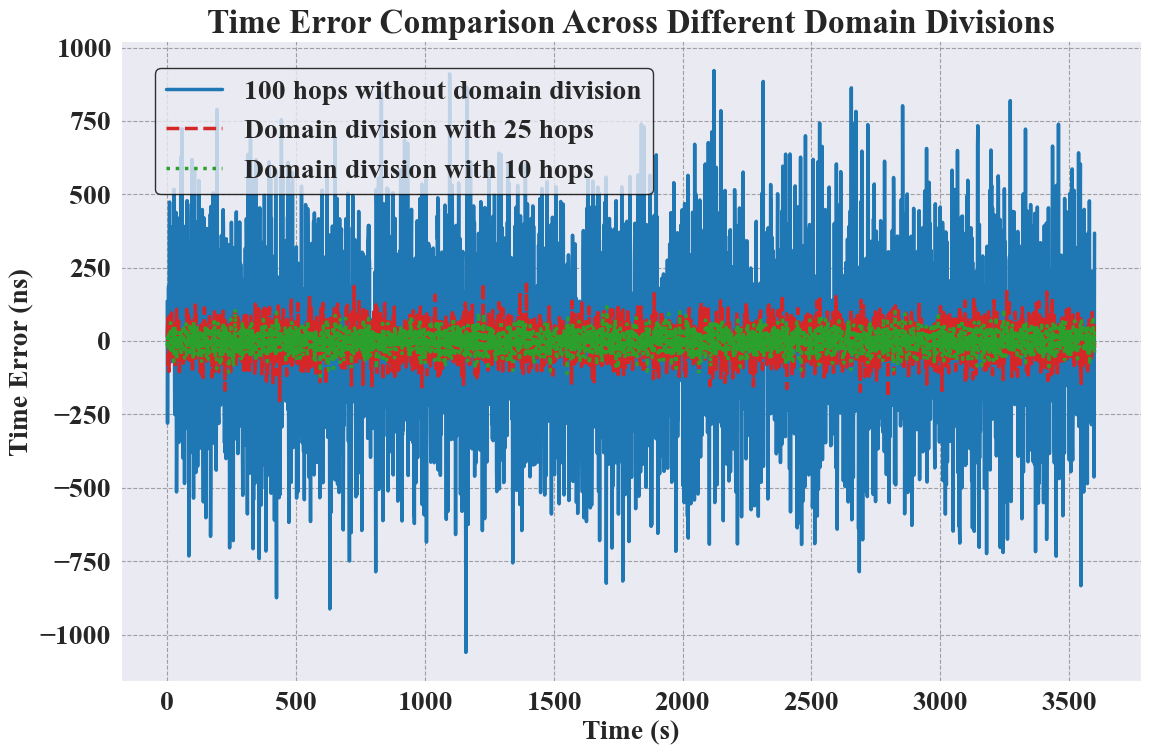

折线图已保存到: output_domains\time_error_comparison.png

所有处理完成！


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 定义文件路径
file1 = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\te_all_hops.csv"
file2 = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250430\output_data\case1_data.csv"
file3 = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250430\output_data\case2_data.csv"

# 2. 创建输出目录
output_dir = "output_domains"
os.makedirs(output_dir, exist_ok=True)
print(f"数据将保存到: {output_dir}")

# 3. 数据预处理函数
def preprocess_data(data_col):
    """处理数据列，去除NaN值并转换为numpy数组"""
    data = data_col.values
    data = np.nan_to_num(data, nan=np.nanmean(data))
    return data

# 4. 读取并处理数据
try:
    # 读取第一组数据 (Hop_100)
    df1 = pd.read_csv(file1)
    print("\n文件1加载成功！前5行示例：")
    print(df1.head())
    
    data1 = preprocess_data(df1["Hop_100"])
    print(f"处理数据1: 有效数据点={len(data1)}")
    
    # 读取第二组数据 (Hop_11)
    df2 = pd.read_csv(file3)
    print("\n文件2加载成功！前5行示例：")
    print(df2.head())
    
    data2 = preprocess_data(df2["Hop_100"])
    print(f"处理数据2: 有效数据点={len(data2)}")
    
    # 读取第三组数据 (Hop_5)
    df3 = pd.read_csv(file2)
    print("\n文件3加载成功！前5行示例：")
    print(df3.head())
    
    data3 = preprocess_data(df3["Hop_100"])
    print(f"处理数据3: 有效数据点={len(data3)}")
    
except Exception as e:
    print(f"\n数据文件加载失败: {e}")
    raise

# 5. 创建结果DataFrame并保存
result_df = pd.DataFrame({
    "100 hops without domain division": data1,
    "Domain division with 25 hops": data2,
    "Domain division with 10 hops": data3
})

output_csv_path = os.path.join(output_dir, "data_domains.csv")
result_df.to_csv(output_csv_path, index=False)
print(f"\n所有数据已合并保存到: {output_csv_path}")

# 6. 绘制折线图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#d62728', '#2ca02c']  # 蓝,红,绿
linestyles = ['-', '--', ':']
linewidths = [2.5, 2.5, 2.5]

# 绘制三组数据
x = np.arange(len(data1))  # 假设三组数据长度相同
ax.plot(x, data1, 
        color=colors[0], 
        linestyle=linestyles[0],
        linewidth=linewidths[0],
        label='100 hops without domain division')

ax.plot(x, data2, 
        color=colors[1], 
        linestyle=linestyles[1],
        linewidth=linewidths[1],
        label='Domain division with 25 hops')

ax.plot(x, data3, 
        color=colors[2], 
        linestyle=linestyles[2],
        linewidth=linewidths[2],
        label='Domain division with 10 hops')

# 设置图表属性
ax.set_xlabel('Time (s)', fontweight='bold')
ax.set_ylabel('Time Error (ns)', fontweight='bold')
ax.set_title('Time Error Comparison Across Different Domain Divisions', fontweight='bold')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)

# 修改图例位置和样式 - 放在左上角内部
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                  frameon=True, framealpha=0.8, edgecolor='black')

# 调整布局以留出足够空间
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

# 保存图表
output_plot_path = os.path.join(output_dir, "time_error_comparison.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"折线图已保存到: {output_plot_path}")

print("\n所有处理完成！")


# TDEV


数据加载成功！前5行示例：
   100 hops without domain division  Domain division with 25 hops  \
0                        135.647245                     12.250760   
1                       -279.636803                     40.609918   
2                        -28.268861                     79.073531   
3                         20.787429                     46.284006   
4                         30.105851                    -94.421745   

   Domain division with 10 hops  
0                    -17.199446  
1                      7.151423  
2                    -13.477589  
3                     26.739840  
4                    -17.744270  
数据将保存到: output_data
图片将保存到: output_image

处理 100 hops without domain division: 有效数据点=3600

处理 Domain division with 25 hops: 有效数据点=3600

处理 Domain division with 10 hops: 有效数据点=3600

所有TDEV数据（秒单位）已保存到: output_data\all_tdev_results_domains_seconds.csv


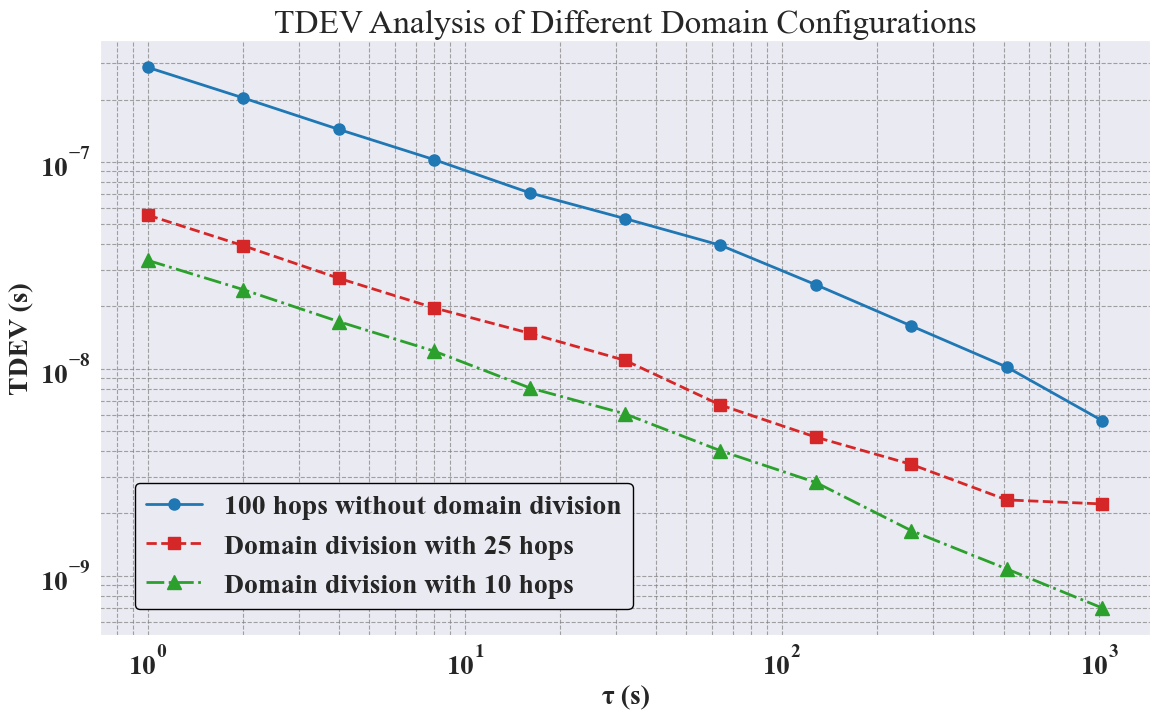

组合TDEV图（秒单位）已保存到: output_image\combined_tdev_plot_domains_seconds.png

所有处理完成！


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 加载CSV文件
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250430\output_domains\data_domains.csv"
try:
    df = pd.read_csv(file_path)
    print("数据加载成功！前5行示例：")
    print(df.head())
except Exception as e:
    print(f"文件加载失败: {e}")
    exit()

# 2. 数据预处理函数（新增纳秒转秒）
def preprocess_data(hop_data):
    time_errors_ns = hop_data.values  # 原始数据单位：纳秒
    time_errors = time_errors_ns / 1e9  # 转换为秒
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame（动态扩展）
all_tdev_results = pd.DataFrame()
column_names = [
    "100 hops without domain division",
    "Domain division with 25 hops",
    "Domain division with 10 hops"
]

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#d62728', '#2ca02c']
linestyles = ['-', '--', '-.']
markers = ['o', 's', '^']
marker_sizes = [8, 8, 10]

# 6. 遍历每一列
for idx, col_name in enumerate(column_names):
    try:
        # 处理数据
        hop_data = df[col_name]
        time_errors, fs = preprocess_data(hop_data)
        print(f"\n处理 {col_name}: 有效数据点={len(time_errors)}")

        # 计算自定义tau数组 [2^0, 2^1, ..., 2^n < 1800]
        max_tau = len(time_errors) // 2  # 3600/2 = 1800
        custom_taus = []
        n = 0
        while True:
            current_tau = 2 ** n
            if current_tau >= max_tau:
                break
            custom_taus.append(current_tau)
            n += 1
        
        # 计算TDEV（单位：秒）
        taus, tdev, _, _ = allantools.tdev(
            data=time_errors,
            rate=fs,
            data_type="phase",
            taus=custom_taus  # 使用自定义tau数组
        )

        # 动态存储结果
        temp_df = pd.DataFrame({
            f"tau_{col_name}": taus,
            f"tdev_{col_name}": tdev
        })
        
        if all_tdev_results.empty:
            all_tdev_results = temp_df
        else:
            all_tdev_results = pd.concat([all_tdev_results, temp_df], axis=1)

        # 绘制到组合图中
        ax.loglog(taus, tdev, 
                 color=colors[idx], 
                 linestyle=linestyles[idx],
                 marker=markers[idx],
                 markersize=marker_sizes[idx],
                 markevery=1,  # 确保所有点都标记
                 linewidth=2,
                 label=col_name)

    except Exception as e:
        print(f"处理 {col_name} 时出错: {e}")
        continue

# 7. 保存所有TDEV结果到CSV（单位：秒）
output_csv_path = os.path.join(output_data_dir, "all_tdev_results_domains_seconds.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据（秒单位）已保存到: {output_csv_path}")

# 8. 完善并保存组合图
ax.set_xlabel('τ (s)')
ax.set_ylabel('TDEV (s)')  # 单位标注为秒
ax.set_title('TDEV Analysis of Different Domain Configurations')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)

# 修改图例位置为左下角，并调整边框和间距
ax.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), 
          framealpha=1, edgecolor='black', frameon=True)


plt.tight_layout(rect=[0, 0, 1, 0.95])  # 为图例预留顶部空间


# 保存组合图
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_domains_seconds.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图（秒单位）已保存到: {output_plot_path}")

print("\n所有处理完成！")


# 计算所有跳数的TE的绝对值的最大值